In [1]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.applications import DenseNet201

# DENSENET

In [2]:
densenet = DenseNet201(include_top=False, pooling='avg')
densenet_model = Sequential()
densenet_model.add(densenet)
densenet_model.add(Dense(1, ))

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
print (densenet_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________
None


In [4]:
densenet_model.load_weights("model_save/DenseNet.h5")

# Importation des données

In [5]:
import logging
logging.basicConfig(level=logging.WARNING)

import math
import os
import random
import collections

import numpy as np
from numpy.lib.stride_tricks import as_strided

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, Activation, concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LambdaCallback, ModelCheckpoint
#from keras.applications.densenet import DenseNet169

from keras.preprocessing import image
from PIL import Image
# import cv2
from skimage.restoration import denoise_wavelet

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 150

import pandas as pd
# from tqdm import tqdm_notebook

Using TensorFlow backend.


In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from keras import backend as K
from keras.models import Model
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.utils import get_file
from keras.utils import get_source_inputs
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape

In [7]:
DIR = './data/SCUT-FBP5500_v2/'

In [8]:
import pandas as pd
import xlrd

In [9]:
df = pd.read_excel(DIR + 'All_Ratings.xlsx')

In [10]:
from collections import defaultdict
import numpy as np
all_images = defaultdict(list)
for filename, rating in df[['Filename', 'Rating']].values:
    all_images[filename].append(rating)
for filename, rating in df[['Filename', 'Rating']].values:
    all_images[filename].append(rating)
data = {}
for filename, ratings in all_images.items():
    data[filename] = np.mean(ratings)
ratings = dict(data)

In [11]:
import os
from keras.preprocessing import image
images = []
ys = []
for filename in os.listdir(DIR + '/Images'):
    img_path = DIR + '/Images/' + filename
    img=image.load_img(img_path)
    img=image.img_to_array(img)
    images.append(img)
    ys.append(ratings[filename])
    

In [12]:
import matplotlib.pyplot as plt
import random
all_data = pd.DataFrame(data={'image': images, 'rating': ys})

In [13]:
train_size = int(len(all_data)*0.8)
train_data = all_data[:train_size]
test_data = all_data[train_size:]

train_images = train_data['image']
train_ys = train_data['rating']

train_images = list(train_images)
train_ys = list(train_ys)

test_images = test_data['image']
test_ys = test_data['rating']
test_images = list(test_images)
test_ys = list(test_ys)

train_X = np.array(train_images)
train_Y = np.array(train_ys)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_Y.reshape(-1, 1))
train_Y = scaler.transform(train_Y.reshape(-1, 1))
test_X = np.array(test_images)
test_Y = np.array(test_ys)
test_Y = scaler.transform(test_Y.reshape(-1, 1))

# Test approfondi du DenseNet

In [15]:
densenet_predict = scaler.inverse_transform(densenet_model.predict(test_X))
Y = scaler.inverse_transform(test_Y)

In [16]:
Y_1D = [float(x[0]) for x in Y]

In [17]:
def quantile(x,n):
    return pd.qcut(x,n,duplicates ='drop')

In [18]:
def rang(x,n,Y):
    qual = 0
    quant = quantile(Y,n)
    for i in range(n):
        if x in quant.categories[i]:
            qual=i+1
    return qual

In [19]:
def matches_eval(nb_random=10000,nb_non_random=500,nb_image=1000,n_tile=10,err=0):
    liste,score = data(nb_image)
    mat=matrice_diff(score)
    score=random_match(nb_random,score,err,mat)
    non_random(nb_non_random,score,err,mat)
    y_pred = [quality(x,n_tile,score) for x in score]
    y_true = [quality(x,n_tile,liste) for x in liste]
    precision=precision_score(y_true, y_pred,average=None,labels=[n_tile])  
    return float(precision)

In [20]:
y_pred = [rang(x,10,Y_1D) for x in densenet_predict]
y_true = [rang(x,10,Y_1D) for x in Y_1D]

In [21]:
from sklearn.metrics import confusion_matrix

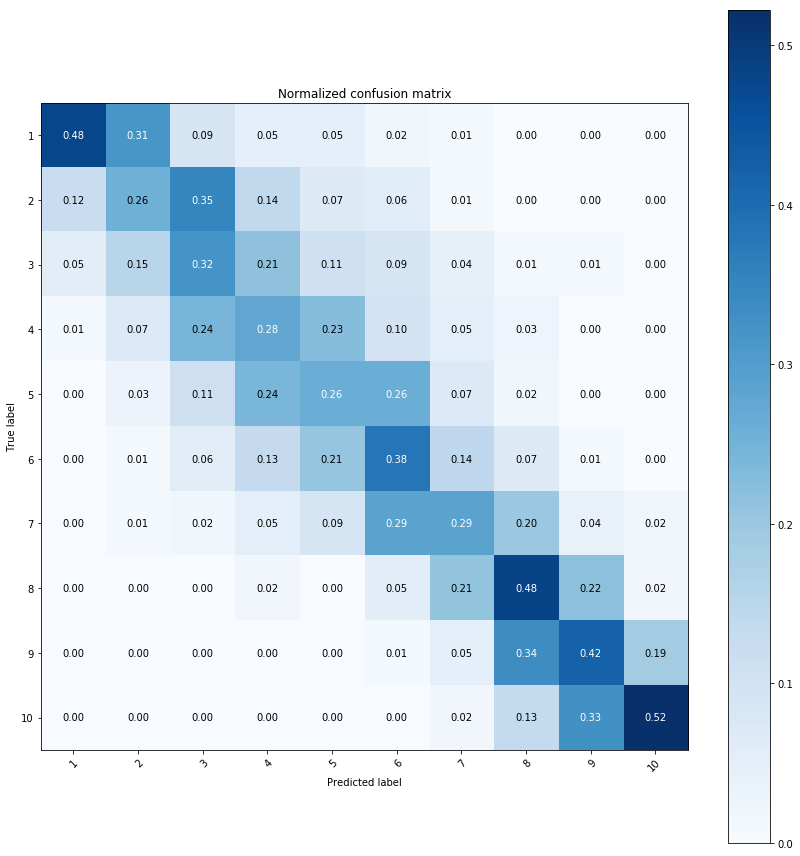

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5,6,7,8,9,10])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.rcParams["figure.figsize"] = (12,12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']

plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')

plt.show()

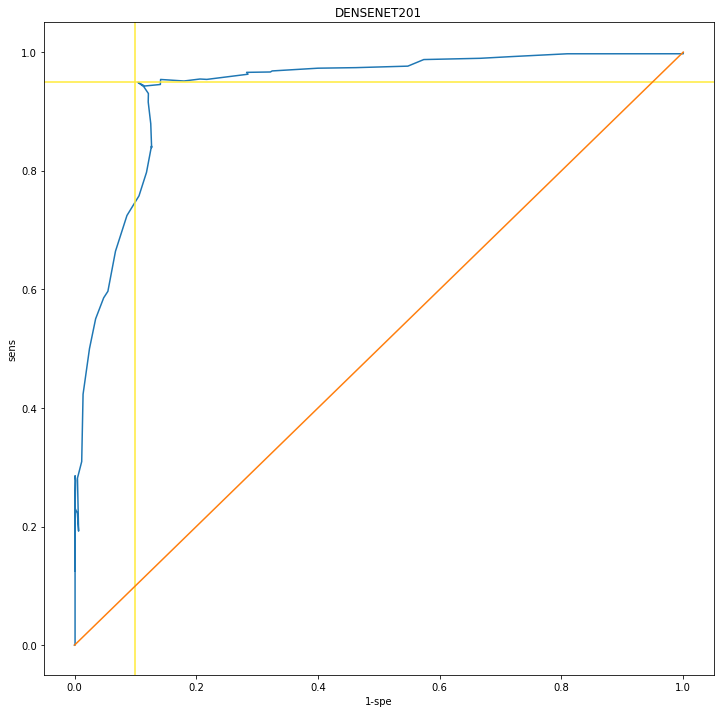

In [23]:
from sklearn.metrics import confusion_matrix
P = [float(x[0]) for x in densenet_predict]
Y = [float(x[0]) for x in scaler.inverse_transform(test_Y)]
seuil = np.linspace(np.min(P),np.max(P))
sensitivity1 = []
specificity1 = []
for i in seuil:
    Y_true = [1 if x >= i  else 0 for x in Y]
    Y_pred = [1 if x >= i  else 0 for x in P]
    cm1 = confusion_matrix(Y_true,Y_pred)
    sensitivity1.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    specificity1.append(1 - (cm1[1,1]/(cm1[1,0]+cm1[1,1])))

plt.plot(specificity1,sensitivity1)
plt.title('DENSENET201')
plt.xlabel('1-spe')
plt.ylabel('sens')
plt.axhline(y=0.95, color='#ffeb38', linestyle='-')
plt.axvline(x=0.1, color='#ffeb38', linestyle='-')

plt.plot([0,1],[0,1])
    

In [24]:
i=seuil[29]
Y_true = [1 if x >= i  else 0 for x in Y]
Y_pred = [1 if x >= i  else 0 for x in P]
cm1 = confusion_matrix(Y_true,Y_pred)
sensitivity1.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
specificity1.append(1 - (cm1[1,1]/(cm1[1,0]+cm1[1,1])))

In [25]:
cm1

array([[707,  38],
       [ 37, 318]])

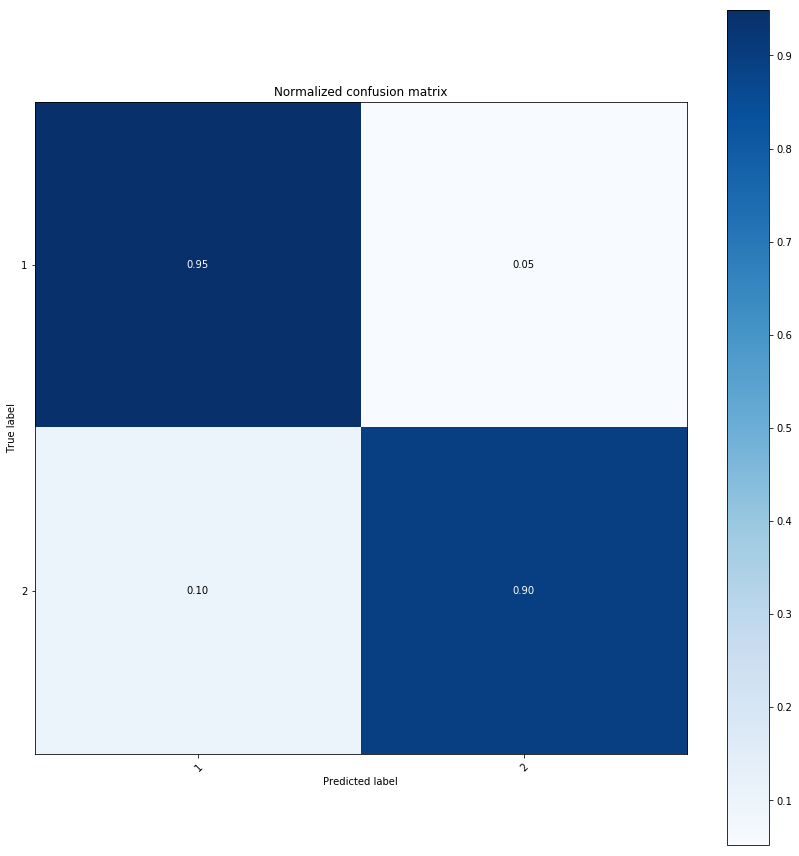

In [26]:
def plot_confusion_matrix_bin(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred,labels=[0,1])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.rcParams["figure.figsize"] = (12,12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
class_names=['1','2']

plot_confusion_matrix_bin(Y_true, Y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [27]:
from sklearn.metrics import precision_score
precision_score(Y_true,Y_pred,average=None)

array([0.95, 0.89])

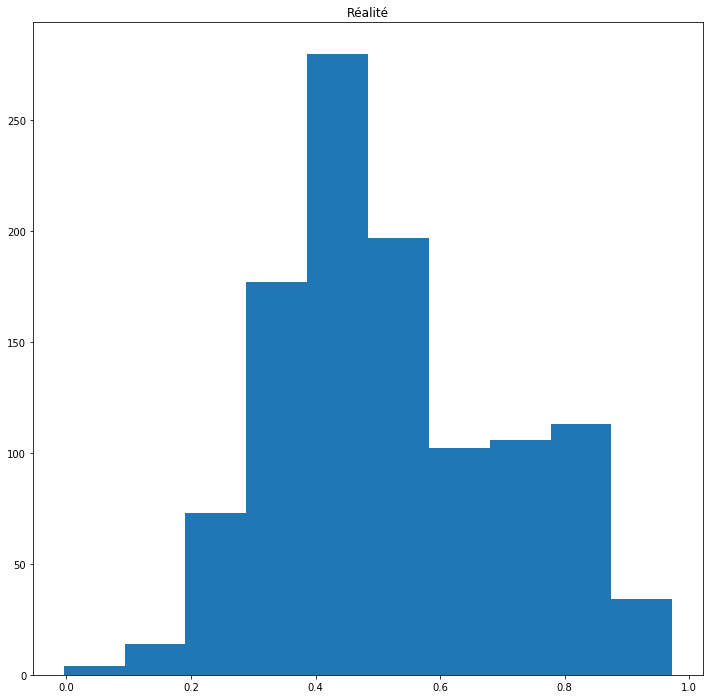

In [28]:
plt.hist(test_Y)
plt.title('Réalité')
plt.show()

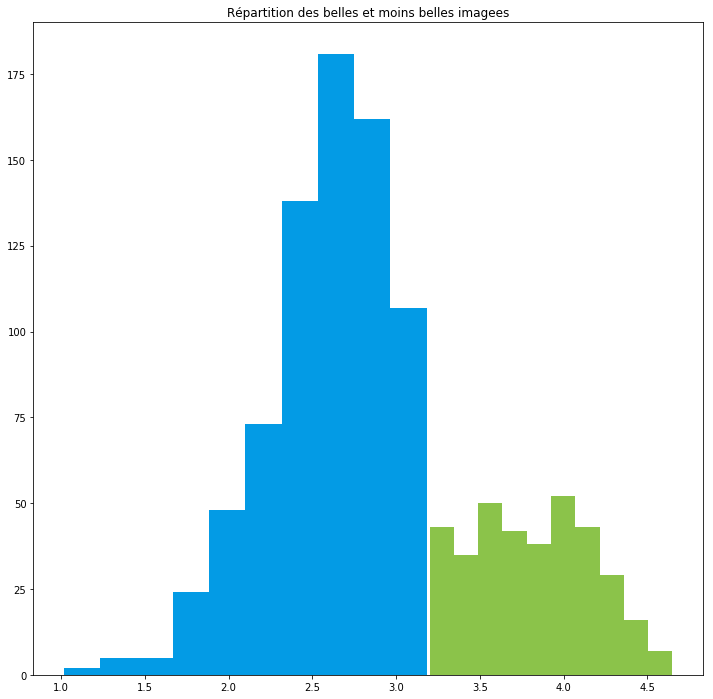

In [29]:
plt.hist([x for x in Y if x<i],color='#039be5')

plt.hist([x for x in Y if x>=i],color='#8bc34a')
plt.title('Répartition des belles et moins belles imagees')
plt.show()

In [186]:
pourcentage =["0%" ,  "5%",  "10%",  "15%",  "20%" ,  "25%",  "30%" ,  "35%",  "40%" ,  "45%",  "50%" ,
        "55%",  "60%" ,  "65%",  "70%" , "75%",  "80%" ,  "85%",  "90%" ,  "95%", "100%" ]
rappel_0 = [0]
rappel_1 = [100]
precision_1 = [100]

for i in np.linspace(1.2,max(Y),20):
    Y_true = [1 if x >= i  else 0 for x in Y]
    Y_pred = [1 if x >= i  else 0 for x in P]
    cm1 = confusion_matrix(Y_true,Y_pred)
    rappel_0.append(cm1[0,0]/(cm1[0,0]+cm1[0,1])*100)
    rappel_1.append(cm1[1,1]/(cm1[1,0]+cm1[1,1])*100)
    precision_1.append(cm1[1,1]/(cm1[0,1]+cm1[1,1])*100)
precision_1[-1] = 0
rappel_0 = [str(int(x))+'%' for x in rappel_0]
rappel_1 = [str(int(x))+'%' for x in rappel_1]
precision_1 = [str(int(x))+'%' for x in precision_1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [189]:
pd.DataFrame({'pourcentage':pourcentage,
             'rappel_0': rappel_0,
             'rappel_1':rappel_1,
             'precision_1':precision_1})


,pourcentage,precision_1,rappel_0,rappel_1
0,0%,100%,0%,100%
1,5%,99%,0%,99%
2,10%,99%,25%,99%
3,15%,99%,33%,99%
4,20%,98%,27%,99%
5,25%,97%,22%,99%
6,30%,94%,33%,98%
7,35%,93%,52%,97%
8,40%,89%,61%,93%
9,45%,87%,74%,90%


In [188]:
pourcentage =["0%" ,  "5%",  "10%",  "15%",  "20%" ,  "25%",  "30%" ,  "35%",  "40%" ,  "45%",  "50%" ,
        "55%",  "60%" ,  "65%",  "70%" , "75%",  "80%" ,  "85%",  "90%" ,  "95%", "100%" ]
rappel_0 = [0]
rappel_1 = [100]
precision_1 = [100]

for i in np.linspace(1.2,max(P),20):
    Y_true = [1 if x >= i  else 0 for x in Y]
    Y_pred = [1 if x >= i  else 0 for x in P]
    cm1 = confusion_matrix(Y_true,Y_pred)
    rappel_0.append(cm1[0,0]/(cm1[0,0]+cm1[0,1])*100)
    rappel_1.append(cm1[1,1]/(cm1[1,0]+cm1[1,1])*100)
    precision_1.append(cm1[1,1]/(cm1[0,1]+cm1[1,1])*100)
precision_1[-1] = 0
rappel_0 = [str(int(x))+'%' for x in rappel_0]
rappel_1 = [str(int(x))+'%' for x in rappel_1]
precision_1 = [str(int(x))+'%' for x in precision_1]

In [147]:
P = [float(x[0]) for x in densenet_predict]
Y = [float(x[0]) for x in scaler.inverse_transform(test_Y)]
np.linspace(np.min(Y),np.max(Y),21)

array([1.02, 1.2 , 1.38, 1.56, 1.74, 1.93, 2.11, 2.29, 2.47, 2.65, 2.83,
       3.02, 3.2 , 3.38, 3.56, 3.74, 3.92, 4.11, 4.29, 4.47, 4.65])

In [194]:
Y_true = [1 if x >= np.linspace(np.min(Y),np.max(Y),21)[12]  else 0 for x in Y]
Y_pred = [1 if x >= np.linspace(np.min(Y),np.max(Y),21)[12]  else 0 for x in P]
cm1 = confusion_matrix(Y_true,Y_pred)

In [196]:
 tn, fp, fn, tp = confusion_matrix(Y_true,Y_pred).ravel()

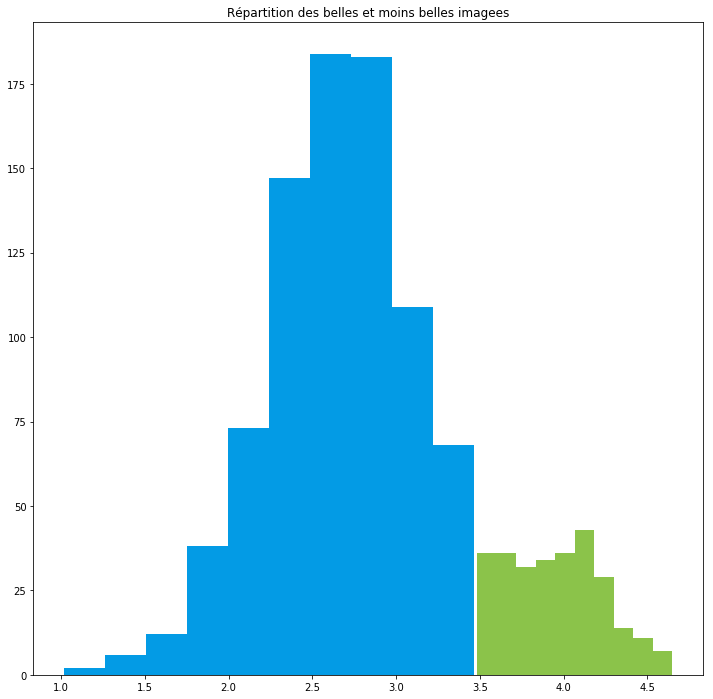

In [38]:
i_5 = seuil[33]

plt.hist([x for x in Y if x<i_5],color='#039be5')
plt.hist([x for x in Y if x>=i_5],color='#8bc34a')
plt.title('Répartition des belles et moins belles imagees')
plt.show()

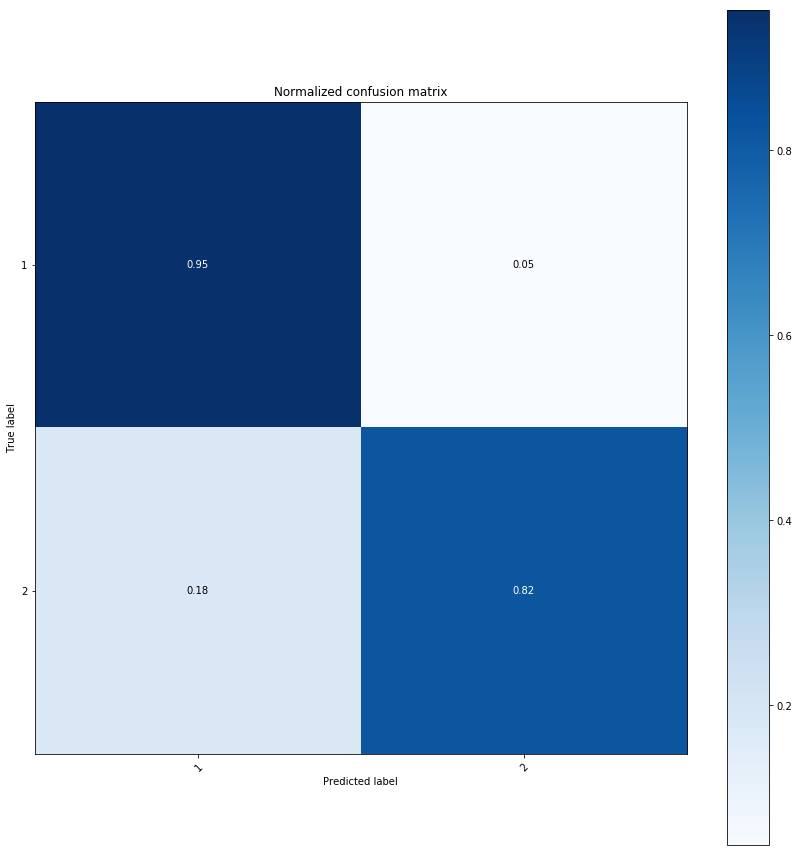

In [45]:
plot_confusion_matrix_bin(Y_true, Y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')

plt.show()

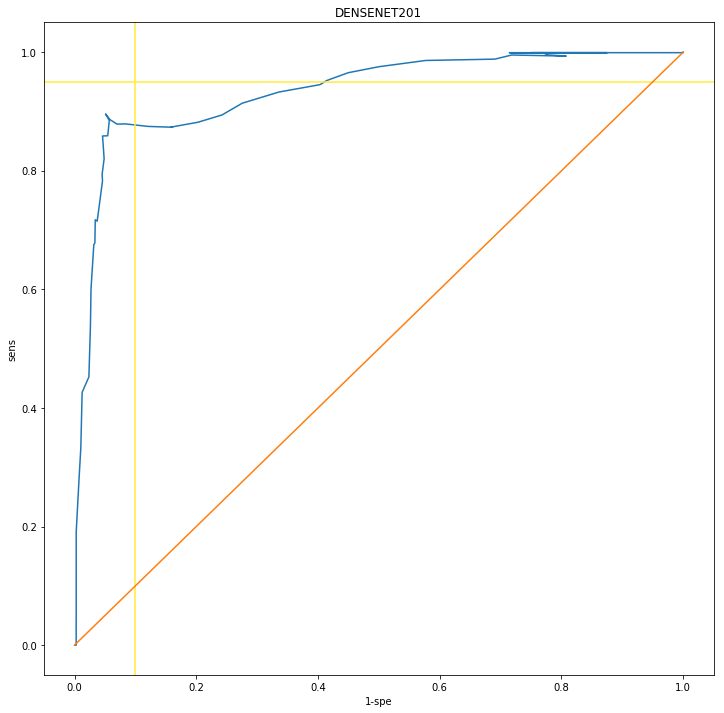

In [67]:
from sklearn.metrics import confusion_matrix
P = [float(x[0]) for x in densenet_predict]
Y = [float(x[0]) for x in scaler.inverse_transform(test_Y)]
seuil = np.linspace(np.min(P),np.max(P))
sensitivity1 = []
specificity1 = []
for i in seuil:
    Y_true = [1 if x >= i  else 0 for x in Y]
    Y_pred = [1 if x >= i  else 0 for x in P]
    cm1 = confusion_matrix(Y_true,Y_pred)
    sensitivity1.append(cm1[1,1]/(cm1[1,1]+cm1[1,0]))
    specificity1.append(1 - (cm1[0,0]/(cm1[0,1]+cm1[0,0])))

plt.plot(specificity1,sensitivity1)
plt.title('DENSENET201')
plt.xlabel('1-spe')
plt.ylabel('sens')
plt.axhline(y=0.95, color='#ffeb38', linestyle='-')
plt.axvline(x=0.1, color='#ffeb38', linestyle='-')

plt.plot([0,1],[0,1])
    